## Kaggle 데이터 불러오기

In [11]:
# from google.colab import files
# files.upload()

In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

# 파일 다운로드
!kaggle datasets download -d fedesoriano/company-bankruptcy-prediction

company-bankruptcy-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
!unzip company-bankruptcy-prediction.zip

Archive:  company-bankruptcy-prediction.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.csv                


## 기준모델

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


df_origin = pd.read_csv("data.csv")
df, df_test = train_test_split(df_origin, test_size=0.2)

target = 'Bankrupt?'

## 기준 모델
base_accuracy = df_test[target].value_counts(normalize=True)[0]
print("기준모델 정확도: ", base_accuracy)

기준모델 정확도:  0.9743401759530792


## Oversampling 통해 데이터 편향 해결

In [15]:
from imblearn.over_sampling import SMOTE


## Oversampling 통해 데이터 편향 해결
oversample = SMOTE(random_state=2)

X_a = df.drop(labels=[target], axis=1)
y_a = df[target]

X, y = oversample.fit_resample(X_a, y_a)
X = pd.DataFrame(X, columns=X_a.columns)
y = pd.DataFrame(y, columns=['Bankruptcy?'])

print("Oversampling 이후 기준모델 정확도: ", y.value_counts(normalize=True)[0])

Oversampling 이후 기준모델 정확도:  Bankruptcy?
0              0.5
dtype: float64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Train & Validation Data Split

In [16]:
## Train & Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## <Model 1>
## Random Forest Classifier 학습시키기

In [17]:
pip install category_encoders

In [18]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

## Random Forest Classifier
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=2)
)

pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(boo...p=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                        

## Random Forest Classifier 예측하기

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4209
           1       1.00      1.00      1.00      4223

    accuracy                           1.00      8432
   macro avg       1.00      1.00      1.00      8432
weighted avg       1.00      1.00      1.00      8432

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1061
           1       0.96      1.00      0.98      1047

    accuracy                           0.98      2108
   macro avg       0.98      0.98      0.98      2108
weighted avg       0.98      0.98      0.98      2108

AUC: 0.9797171938674927


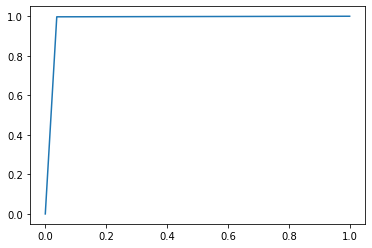

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import numpy as np


## 데이터 예측하기
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)

## Confusion Matrix 출력
print(classification_report(y_train,y_train_pred))
print(classification_report(y_val,y_val_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

## Permutation Importance 알아보기

In [20]:
pip install eli5

     |████████████████████████████████| 112kB 6.4MB/s 


In [21]:
from sklearn.pipeline import Pipeline
import warnings
import eli5
from eli5.sklearn import PermutationImportance

## Permutation Importance 활용
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe_per = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
])

pipe_per.fit(X_train, y_train)


## Permutation Part
warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter = PermutationImportance(
    pipe_per.named_steps['rf'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe_per.named_steps['preprocessing'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [22]:
feature_names = X_val.columns.tolist()
print("총 변수의 개수 : ", len(feature_names))
pd.Series(permuter.feature_importances_, feature_names).sort_values()

총 변수의 개수 :  95


 Net Income Flag                                0.000000e+00
 Liability-Assets Flag                          5.401187e-07
 Current Assets/Total Assets                    1.107243e-05
 ROA(A) before interest and % after tax         1.332293e-05
 Inventory and accounts receivable/Net value    1.494328e-05
                                                    ...     
 Retained Earnings to Total Assets              8.640098e-04
 Total debt/Total net worth                     9.120804e-04
 Continuous interest rate (after tax)           1.158555e-03
 Interest-bearing debt interest rate            1.319690e-03
 Borrowing dependency                           1.752685e-03
Length: 95, dtype: float64

In [23]:
 ## 중요하지 않은 변수 삭제
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]

X_train_selected = X_train[features]
X_val_selected = X_val[features]


## 삭제 후 새로운 Pipeline
pipe_sel = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
], verbose=1)

pipe_sel.fit(X_train_selected, y_train)

print("총 변수의 개수 : ", len(X_val_selected.columns.tolist()))
print('시험 정확도 : ', pipe_sel.score(X_val_selected, y_val))

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


[Pipeline] ................ (step 2 of 2) Processing rf, total=   0.7s
총 변수의 개수 :  3
시험 정확도 :  0.9335863377609108


## Permutation Importance 분석으로 불필요한 변수 삭제 후 성능

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      1061
           1       0.91      0.96      0.93      1047

    accuracy                           0.93      2108
   macro avg       0.93      0.93      0.93      2108
weighted avg       0.93      0.93      0.93      2108

AUC: 0.9337598470383943


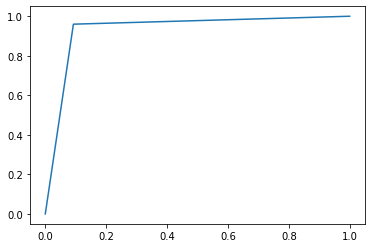

In [24]:
## Confusion Matrix 출력
y_val_selected_pred = pipe_sel.predict(X_val_selected)
print(classification_report(y_val, y_val_selected_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_val, y_val_selected_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

## Oversampling하여 학습한 모델을 비대칭적인 데이터셋에 적용

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1329
           1       0.17      0.63      0.26        35

    accuracy                           0.91      1364
   macro avg       0.58      0.77      0.61      1364
weighted avg       0.97      0.91      0.93      1364

AUC: 0.7725249919380845


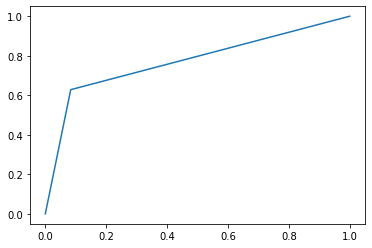

In [25]:
X_test = df_test.drop(labels=[target], axis=1)
X_test_selected = X_test[features]
y_test = df_test[target]

## Confusion Matrix 출력
y_test_selected_pred = pipe_sel.predict(X_test_selected)
print(classification_report(y_test, y_test_selected_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_test_selected_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

In [26]:
## Permutation Importance 활용
# encoder, imputer를 preprocessing으로 묶었습니다. 후에 eli5 permutation 계산에 사용합니다
pipe_per = Pipeline([
    ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)) 
])

pipe_per.fit(X_train_selected, y_train)


## Permutation Part
warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter = PermutationImportance(
    pipe_per.named_steps['rf'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_test_transformed = pipe_per.named_steps['preprocessing'].transform(X_test_selected)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_test_transformed, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [27]:
feature_names = X_test_selected.columns.tolist()
print("총 변수의 개수 : ", len(feature_names))
pd.Series(permuter.feature_importances_, feature_names).sort_values()

총 변수의 개수 :  3


 Interest-bearing debt interest rate     0.013503
 Borrowing dependency                    0.095358
 Continuous interest rate (after tax)    0.110659
dtype: float64

## 모두 파산 안한다고(0) 예측할 경우

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1329
           1       0.00      0.00      0.00        35

    accuracy                           0.97      1364
   macro avg       0.49      0.50      0.49      1364
weighted avg       0.95      0.97      0.96      1364

AUC: 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


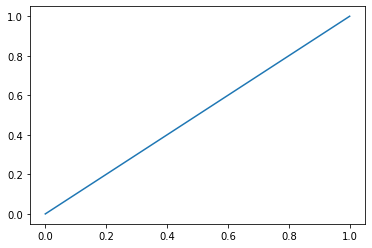

In [28]:
y_deny = pd.DataFrame({'Bankruptcy?':[0]*1364})

## Confusion Matrix 출력
print(classification_report(y_test, y_deny))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_deny, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

변수들을 많이 삭제했음에도 성능을 아주 약간밖에 떨어지지 않음

## Oversampling하지 않고 학습한 모델의 성능

0    0.966086
1    0.033914
Name: Bankrupt?, dtype: float64
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1329
           1       0.45      0.14      0.22        35

    accuracy                           0.97      1364
   macro avg       0.72      0.57      0.60      1364
weighted avg       0.96      0.97      0.97      1364

AUC: 0.5691712350854563


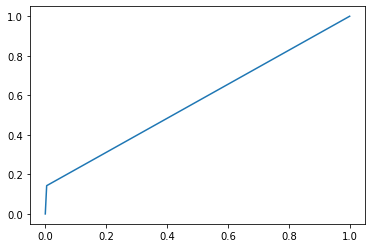

In [29]:
## 원래 데이터에 모델 대입해보기
## 기준모델
base_accuracy_origin = df[target].value_counts(normalize=True)
print(base_accuracy_origin)

### 기본적인 모델
pipe_org = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(),
    RandomForestClassifier(random_state=2)
)

# 중요한 Featrues 추출 후 모델 Fit
X_origin = df.drop(labels=[target], axis=1)[features]
y_origin = df[target]
pipe_org.fit(X_origin, y_origin)

## Confusion Matrix 출력
y_test_origin_pred = pipe_org.predict(X_test_selected)
print(classification_report(y_test, y_test_origin_pred))

## ROC Curve 활용
fpr, tpr, thresholds = roc_curve(y_test, y_test_origin_pred, pos_label = 1)

# ROC curve
plt.plot(fpr,tpr)

# AUC
auc = np.trapz(tpr,fpr)
print("AUC:",auc)

## PDP & SHAP 활용하여 설명하기

In [30]:
pip install pdpbox

     |████████████████████████████████| 34.0MB 89kB/s 
     |████████████████████████████████| 13.1MB 237kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-cp37-none-any.whl size=35758227 sha256=06ebfc307be39ebb5951b323df974c5baae9884f72d34e6a45458d92879def1c
  Stored in directory: /root/.cache/pip/wheels/c8/13/11/ecac74c6192790c94f6f5d919f1a388f927b9febb690e45eef
Successfully built pdpbox
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


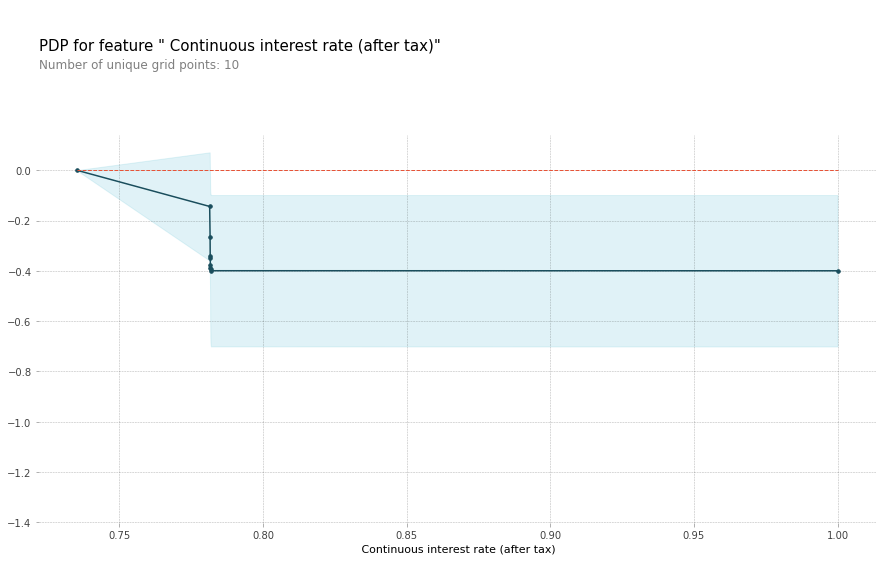

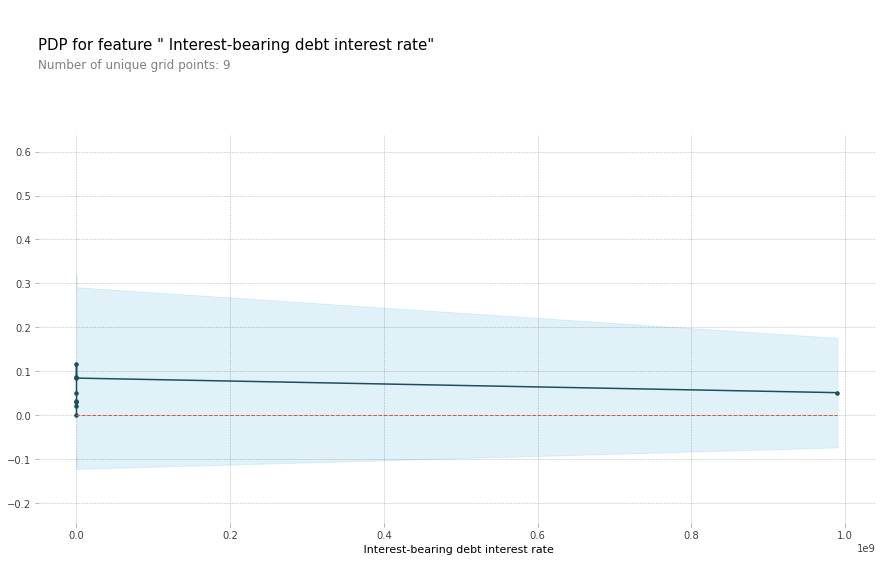

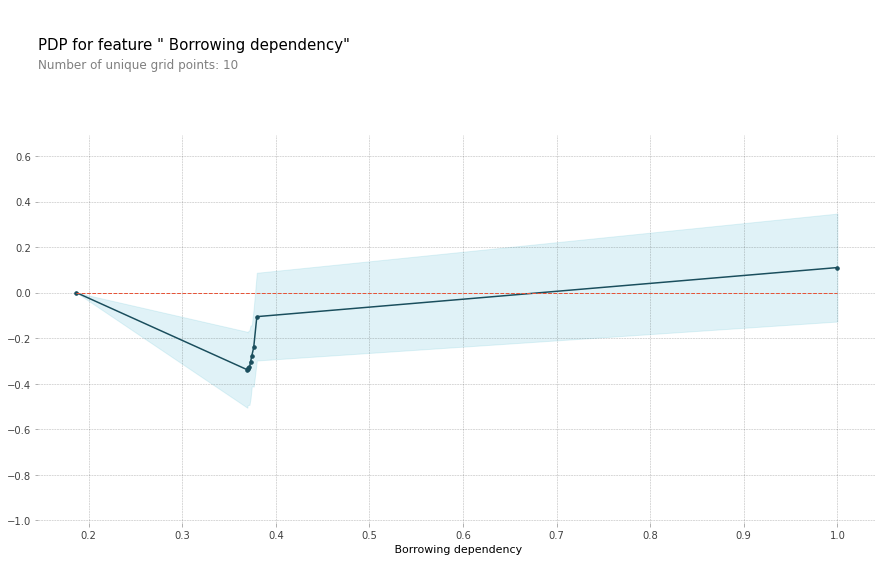

In [31]:
import matplotlib.pyplot as plt
from pdpbox import pdp


preprocessing = pipe_sel.named_steps['preprocessing']
X_preprocessed = preprocessing.fit_transform(X_test_selected)
X_preprocessed = pd.DataFrame(columns=features, data=X_preprocessed)
rf = pipe_sel.named_steps['rf']

for feature in features:
  pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_preprocessed, model_features=features, feature=feature)
  pdp.pdp_plot(pdp_dist, feature)

In [32]:
pip install shap

     |████████████████████████████████| 358kB 6.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491632 sha256=c8a60177a9657db5b6442ec68b0b84cd26245a65a3c70b75aa65ab6744d076ea
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


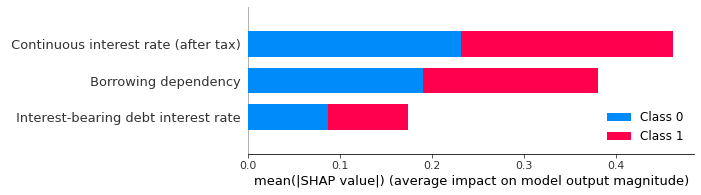

In [33]:
import shap


### SHAP
explainer = shap.TreeExplainer(pipe_sel.named_steps['rf'])
shap_values = explainer.shap_values(X_test_selected.iloc[:300])
shap.summary_plot(shap_values, X_train_selected.iloc[:300])